In [68]:
import numpy as np
import pandas as pd
from ISLP import load_data
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm 
from ISLP.models import (summarize,poly, ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt
import seaborn as sns
from ISLP.transforms import (BSpline, NaturalSpline)
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)
from matplotlib.pyplot import subplots
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)


Applied

6. In this exercise, you will further analyze the Wage data set considered
throughout this chapter.
(a) Perform polynomial regression to predict wage using age. Use
cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to
the results of hypothesis testing using ANOVA? Make a plot of
the resulting polynomial fit to the data.

In [3]:
wage = load_data('Wage')
wage

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154
...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,5.041393,154.685293
2996,2007,30,2. Married,1. White,2. HS Grad,2. Middle Atlantic,1. Industrial,2. >=Very Good,2. No,4.602060,99.689464
2997,2005,27,2. Married,2. Black,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.193125,66.229408
2998,2005,27,1. Never Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,2. >=Very Good,1. Yes,4.477121,87.981033


In [4]:
age =  wage['age'].values.reshape(-1,1)
y = wage['wage'].values
age.shape


(3000, 1)

In [5]:
scores = []
for degree in range(1,7):
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(age)
    model = LinearRegression()
    scores.append(-1 * np.mean(cross_val_score(model,X_poly,y,cv=5,scoring='neg_mean_squared_error')))

scores

[1675.0142380530044,
 1599.5982268539044,
 1594.7262162596821,
 1593.9141039297458,
 1595.433131541959,
 1594.9302253022665]

In [6]:
models = []
for d in range(1,7):
    poly = PolynomialFeatures(d)
    X_poly = poly.fit_transform(age)
    model = sm.OLS(y,sm.add_constant(X_poly)).fit()
    models.append(model)


In [7]:
anova_lm(*models)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.663571,2.285169e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.893609,1.674794e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.811683,5.098933e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805371,3.695646e-01
5,2993.0,4.766389e+06,1.0,3932.256955,2.469216,1.162015e-01


- degree 3 was chosen because its significant and higher degrees does not seem statistically significant.

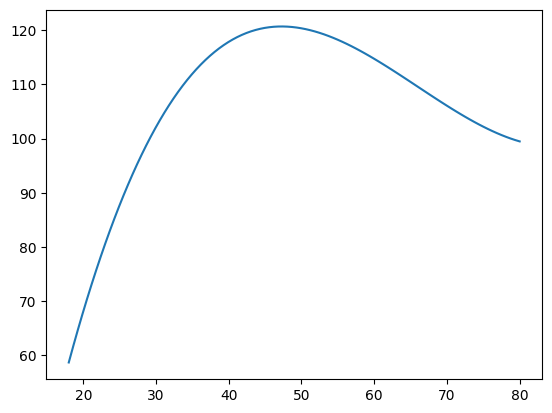

In [8]:
poly = PolynomialFeatures(3)
X_poly = poly.fit_transform(age) 
age_grid = np.linspace(age.min(),age.max(),100).reshape(-1,1)
age_grid_poly = poly.transform(age_grid)
model = sm.OLS(y,sm.add_constant(X_poly)).fit()

preds = model.predict(sm.add_constant(age_grid_poly))
plt.plot(age_grid,preds)

(b) Fit a step function to predict wage using age, and perform crossvalidation to choose the optimal number of cuts. Make a plot of
the fit obtained.

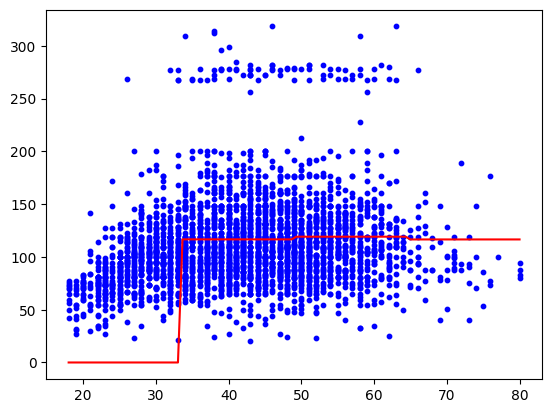

In [9]:
cut_age = pd.qcut(wage['age'],4)
model = sm.OLS(y,pd.get_dummies(cut_age,drop_first=True)).fit()
age_grid = np.linspace(wage['age'].min(), wage['age'].max(), 100)
cut_age_grid = pd.qcut(age_grid,4)
cut_age_grid = pd.get_dummies(cut_age_grid,drop_first=True)

preds_step = model.predict(cut_age_grid)
plt.scatter(wage['age'], y, color='blue', label='Original Data', s=10)
plt.plot(age_grid,preds_step,color='red')

7. The Wage data set contains a number of other features not explored
in this chapter, such as marital status (maritl), job class (jobclass),
and others. Explore the relationships between some of these other
predictors and wage, and use non-linear fitting techniques in order to
fit flexible models to the data. Create plots of the results obtained,
and write a summary of your findings.

In [19]:
X = wage.drop(columns=['wage','logwage'],axis=1)
y = wage.wage.values


In [20]:
X_encoded = pd.get_dummies(X,drop_first=True)
X_encoded

,year,age,maritl_2. Married,maritl_3. Widowed,maritl_4. Divorced,maritl_5. Separated,race_2. Black,race_3. Asian,race_4. Other,education_2. HS Grad,education_3. Some College,education_4. College Grad,education_5. Advanced Degree,jobclass_2. Information,health_2. >=Very Good,health_ins_2. No
0,2006,18,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2004,24,False,False,False,False,False,False,False,False,False,True,False,True,True,True
2,2003,45,True,False,False,False,False,False,False,False,True,False,False,False,False,False
3,2003,43,True,False,False,False,False,True,False,False,False,True,False,True,True,False
4,2005,50,False,False,True,False,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2008,44,True,False,False,False,False,False,False,False,True,False,False,False,True,False
2996,2007,30,True,False,False,False,False,False,False,True,False,False,False,False,True,True
2997,2005,27,True,False,False,False,True,False,False,False,False,False,False,False,False,True
2998,2005,27,False,False,False,False,False,False,False,False,True,False,False,False,True,False


In [55]:
wage.columns

Index(['year', 'age', 'maritl', 'race', 'education', 'region', 'jobclass',
       'health', 'health_ins', 'logwage', 'wage'],
      dtype='object')

In [36]:
X_encoded.dtypes

year                            int64
age                             int64
maritl_2. Married                bool
maritl_3. Widowed                bool
maritl_4. Divorced               bool
maritl_5. Separated              bool
race_2. Black                    bool
race_3. Asian                    bool
race_4. Other                    bool
education_2. HS Grad             bool
education_3. Some College        bool
education_4. College Grad        bool
education_5. Advanced Degree     bool
jobclass_2. Information          bool
health_2. >=Very Good            bool
health_ins_2. No                 bool
dtype: object

In [ ]:
X_encoded = sm.add_constant(np.asarray(X_encoded))

In [43]:
X_encoded = X_encoded.astype(float)
model = sm.OLS(y,X_encoded).fit()
summarize(model)

,coef,std err,t,P>|t|
const,-2423.3291,616.543,-3.931,0.000
x1,1.2412,0.307,4.037,0.000
x2,0.2707,0.062,4.350,0.000
x3,17.1767,1.720,9.985,0.000
x4,2.0517,8.005,0.256,0.798
x5,3.9666,2.887,1.374,0.170
x6,11.5301,4.844,2.380,0.017
x7,-5.0963,2.146,-2.375,0.018
x8,-2.8141,2.603,-1.081,0.280
x9,-6.0588,5.666,-1.069,0.285


<Axes: xlabel='maritl', ylabel='wage'>

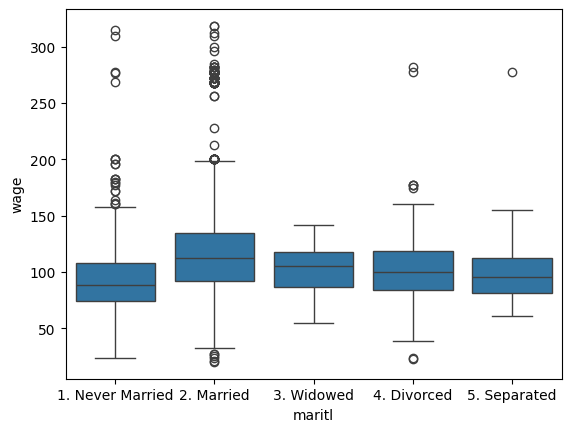

In [57]:
sns.boxplot(x=wage['maritl'],y='wage',data=wage)

<Axes: xlabel='education', ylabel='wage'>

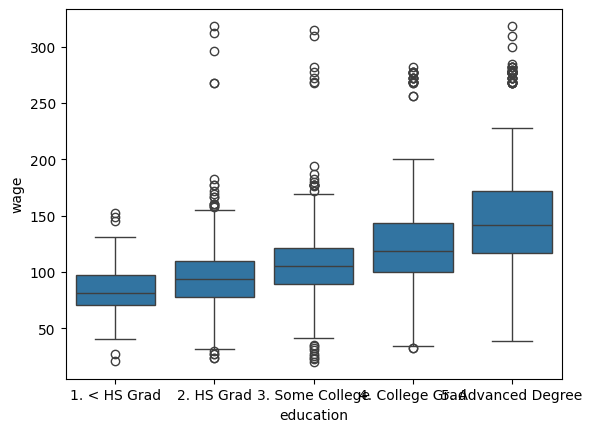

In [58]:
sns.boxplot(x=wage['education'],y='wage',data=wage)

<Axes: xlabel='race', ylabel='wage'>

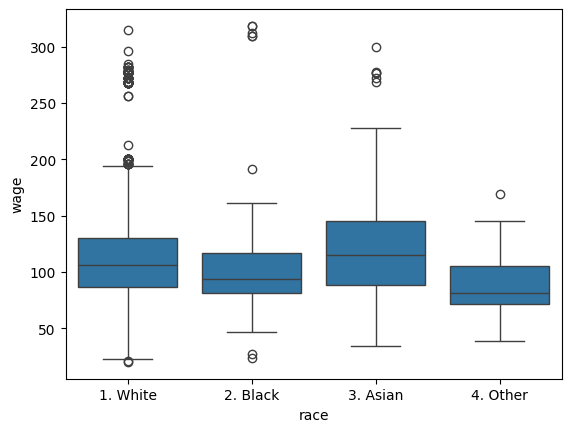

In [59]:
sns.boxplot(x=wage['race'],y=wage.wage,data=wage)

<Axes: xlabel='health', ylabel='wage'>

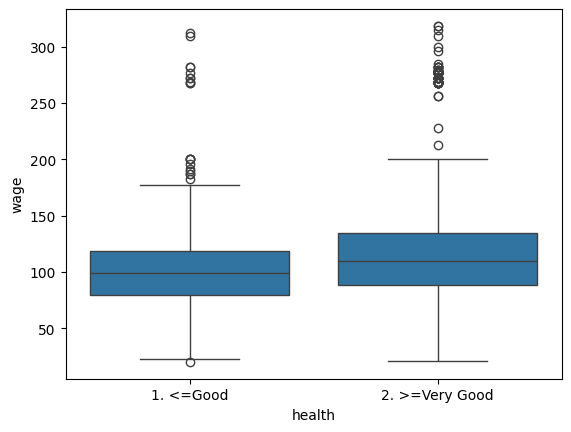

In [60]:
sns.boxplot(x=wage['health'],y=wage['wage'],data=wage)

<Axes: xlabel='jobclass', ylabel='wage'>

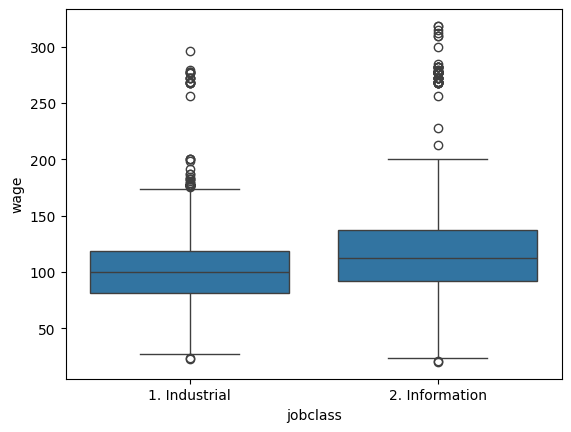

In [63]:
sns.boxplot(x=wage['jobclass'],y=wage.wage,data=wage)

In [64]:
year = wage['year']
ns_age = NaturalSpline(df=4).fit(age)
ns_year = NaturalSpline(df=5).fit(year)
Xs = [ns_age.transform(age),ns_year.transform(year),pd.get_dummies(wage['education']).values, pd.get_dummies(wage['maritl']).values,pd.get_dummies(wage['health']),
      pd.get_dummies(wage['jobclass']).values]
X_bh = np.hstack(Xs)
gam_bh = sm.OLS(y,X_bh).fit()

In [66]:
gam_full = LinearGAM(s_gam(0) + s_gam(1, n_splines=7) + f_gam(2,lam=0) + f_gam(3,lam=0) + f_gam(4,lam=0) + f_gam(5,lam=0))
X_gam = np.column_stack([age,year,wage['education'].cat.codes,wage['maritl'].cat.codes,wage['health'].cat.codes,wage['jobclass'].cat.codes])
gam_full = gam_full.fit(X_gam,y)

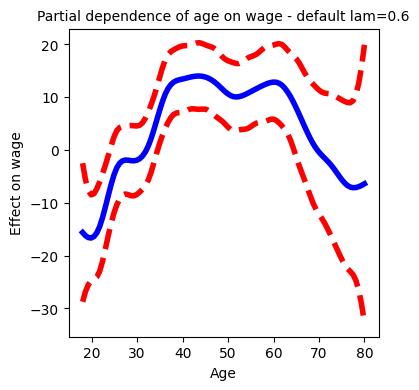

In [75]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 0, ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


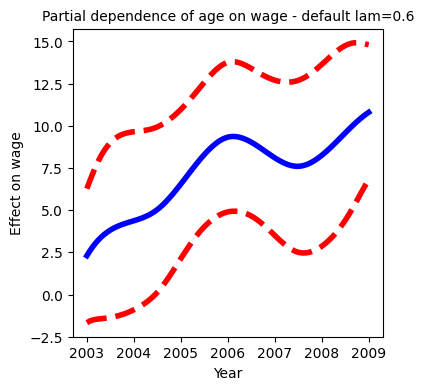

In [74]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 1, ax=ax)
ax.set_xlabel('Year')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


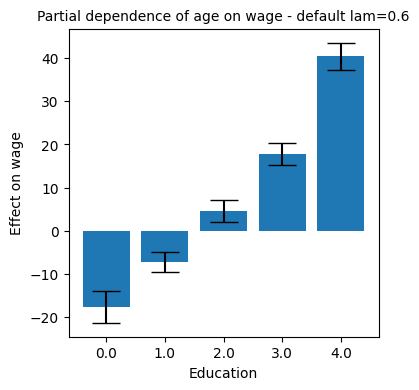

In [79]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 2, ax=ax)
ax.set_xlabel('Education')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


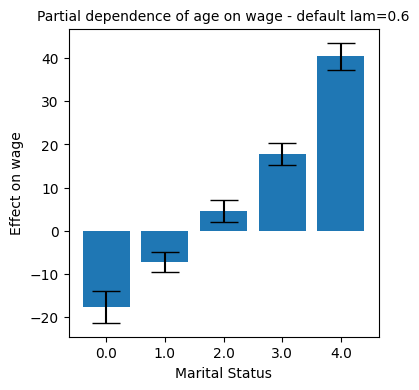

In [80]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 3, ax=ax)
ax.set_xlabel('Marital Status')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


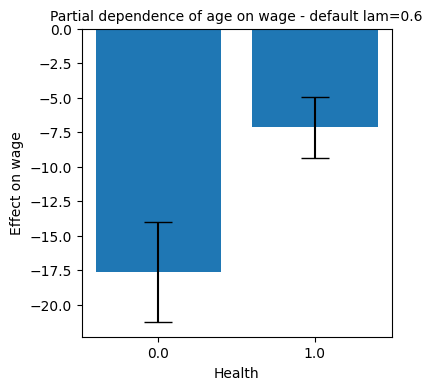

In [81]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 4, ax=ax)
ax.set_xlabel('Health')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


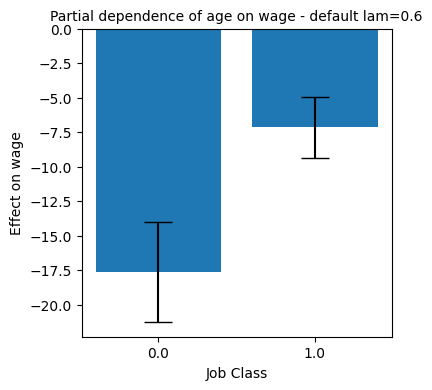

In [82]:
fig, ax = subplots(figsize=(4,4))
plot_gam(gam_full, 5, ax=ax)
ax.set_xlabel('Job Class')
ax.set_ylabel('Effect on wage')
ax.set_title('Partial dependence of age on wage - default lam=0.6', fontsize=10);


8. Fit some of the non-linear models investigated in this chapter to the
Auto data set. Is there evidence for non-linear relationships in this
data set? Create some informative plots to justify your answer.

In [88]:
auto = pd.read_csv('Auto.csv')
auto

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
392,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
393,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
394,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
395,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


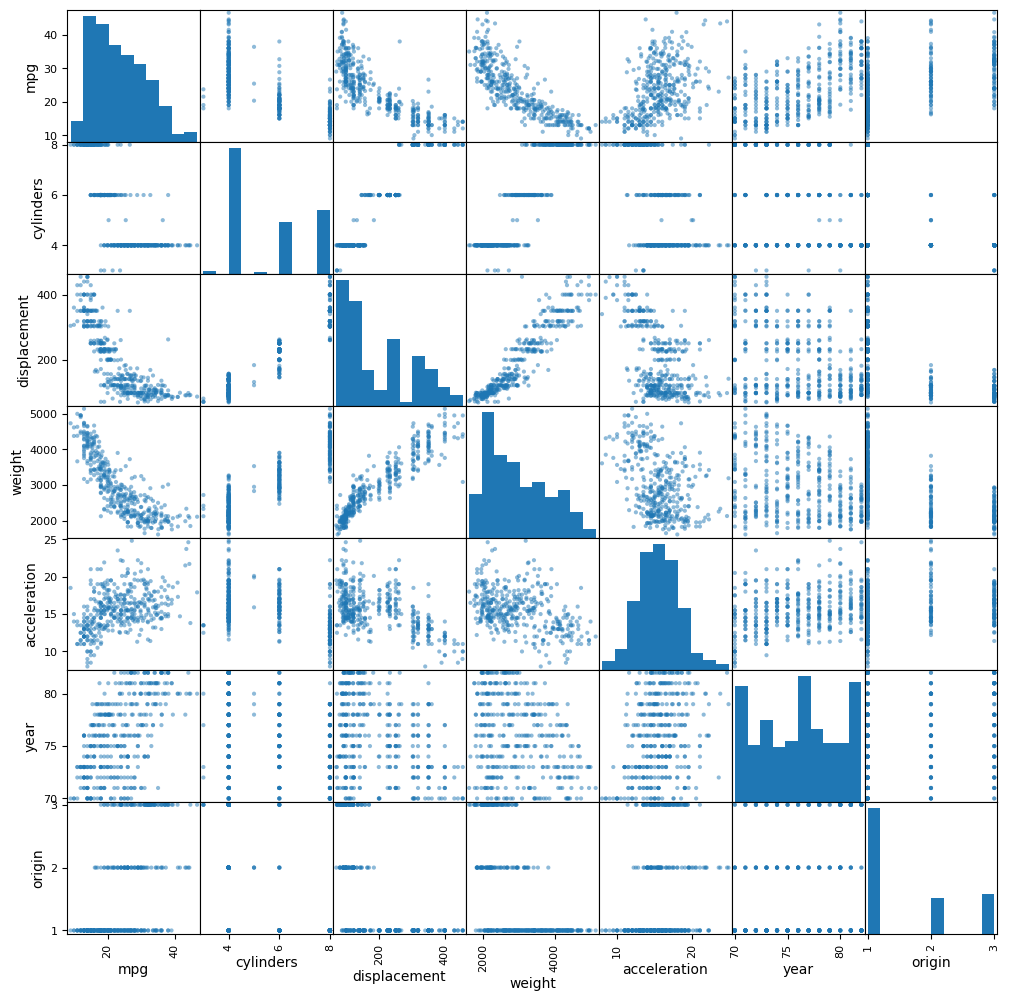

In [91]:
pd.plotting.scatter_matrix(auto,figsize=(12,12));

In [98]:
X_auto = auto[['displacement','weight','acceleration']]
gam = LinearGAM(s_gam(0)+s_gam(1)+s_gam(2)).fit(X_auto,auto['mpg'])


In [99]:
displacement_grid = np.linspace(auto['displacement'].min(),auto['displacement'].max(),100).reshape(-1,1)
weight_grid = np.linspace(auto['weight'].min(),auto['weight'].max(),100).reshape(-1,1)
acceleration_grid = np.linspace(auto['acceleration'].min(),auto['acceleration'].max(),100).reshape(-1,1)
X_grid = np.hstack([displacement_grid,weight_grid,acceleration_grid])


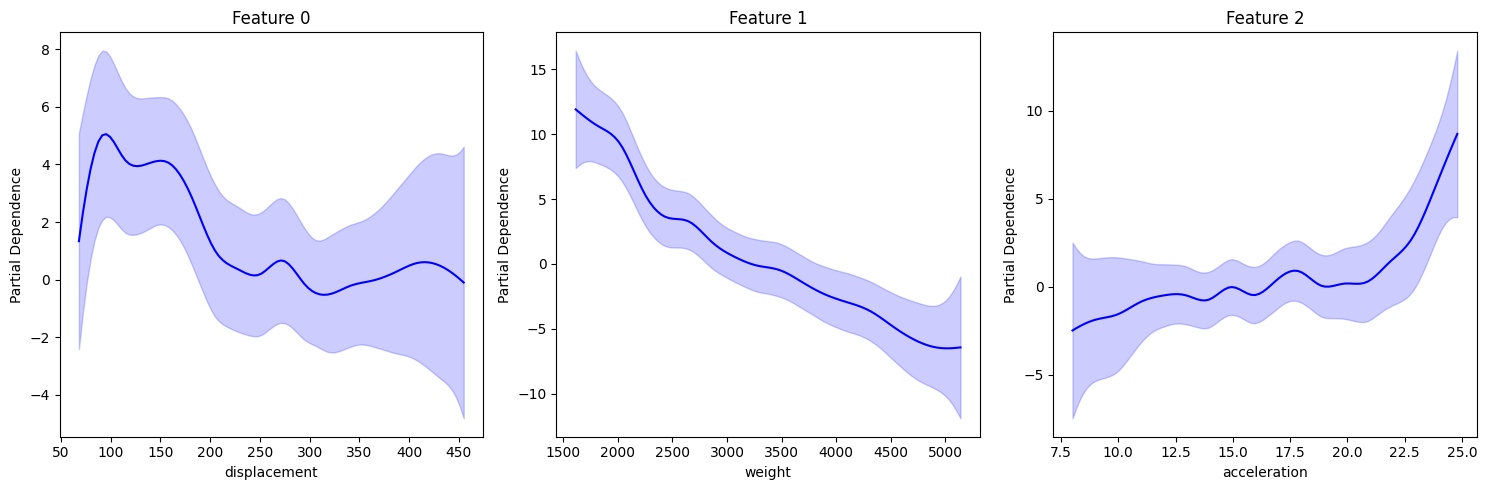

In [106]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)  # Generate grid for the i-th term
    pdep, confi = gam.partial_dependence(term=i, width=0.95)
    
    ax.plot(XX[:, i], pdep, color='blue')  # Plot partial dependence
    ax.fill_between(XX[:, i], confi[:,0], confi[:,1], color='blue', alpha=0.2)  # Plot confidence intervals
    ax.set_title(f'Feature {i}')
    ax.set_xlabel(X_auto.columns[i])
    ax.set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

In [107]:
X_new = np.array([[200, 3000, 15], [150, 2500, 12]])  # Example new data
y_pred_new = gam.predict(X_new)
print("Predictions on new data:", y_pred_new)

Predictions on new data: [20.89803233 25.86325255]


In [115]:
mpg_min = 20  # Lower bound of mpg range
mpg_max = 21  # Upper bound of mpg range

# Filter rows where mpg is within the specified range
filtered_auto = auto[(auto['mpg'] >= mpg_min) & (auto['mpg'] <= mpg_max)]

# Display the filtered rows
print(filtered_auto)

      mpg  cylinders  displacement horsepower  weight  acceleration  year  \
17   21.0          6         200.0         85    2587          16.0    70   
24   21.0          6         199.0         90    2648          15.0    70   
60   20.0          4         140.0         90    2408          19.5    72   
61   21.0          4         122.0         86    2226          16.5    72   
78   21.0          4         120.0         87    2979          19.5    72   
108  20.0          4          97.0         88    2279          19.0    73   
109  21.0          4         140.0         72    2401          19.5    73   
113  21.0          6         155.0        107    2472          14.0    73   
119  20.0          4         114.0         91    2582          14.0    73   
123  20.0          6         156.0        122    2807          13.5    73   
125  20.0          6         198.0         95    3102          16.5    74   
126  21.0          6         200.0          ?    2875          17.0    74   